# **FLOW**

1. 연속형 변수(Income_total, Days_employed, Begin_month, Days_Birth) Minmax Scaling 적용
- Income_total : 4분위수에 근거하여 Outlier 를 Q1, Q3로 대체하였습니다.
- Days_employed : 실직을 뜻하는 양수 값은 0으로 대체하고 나머지 음수 값은 절대값을 취하여 양수로 전환하였습니다.
- Begin_month : 동일 인물로 추정되는 데이터 중 Begin_month 까지 동일한 데이터는 한개씩만 남겨두었습니다.
- Days_Birth : 절대값 /365를 나누고 int로 전환하여 나이를 의미하도록 만들었습니다.

2. 범주형 변수 PART.1(Gender, Car, Reality, income_type)

3. 범주형 변수 PART.2(Family_size, Child_num) 두 컬럼은 경향성이 존재하기 때문에 Ordinal Encoding을 적용했습니다.
- 

3. 파생 변수 


In [45]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.cluster import KMeans

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from tqdm import tqdm

In [9]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

In [11]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n)  for i,j,k,l,m,n in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'], train['begin_month'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n) for i,j,k,l,m,n in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'],test['begin_month'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 21948명
test set 중복데이터가 아닌 사람의 수 : 9303명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 2150명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 344명


In [12]:
subset = train['identity'].value_counts() > 1
subset

F135000.0Pensioner-20752365243-23.0               True
F315000.0Working-13064-2286-33.0                  True
F112500.0Working-13686-1256-2.0                   True
M148500.0Working-11819-962-3.0                    True
M216000.0Commercial associate-19150-7415-18.0     True
                                                 ...  
F90000.0Pensioner-23478365243-14.0               False
M202500.0Working-18281-3596-7.0                  False
F180000.0State servant-15972-5055-13.0           False
F157500.0Working-19176-2959-31.0                 False
F135000.0Pensioner-22504365243-3.0               False
Name: identity, Length: 24098, dtype: bool

In [13]:
drop_list = []

for i in range(len(subset)):
    if subset.values[i] == True:
        drop_list.append(subset.index[i])
    else:
        pass

In [15]:
for i in tqdm(range(len(drop_list))):
    train = train.drop(index = train.loc[train['identity'] == drop_list[i]].sort_values(by=['begin_month']).index[1:] , axis=0)

100%|██████████| 2150/2150 [00:20<00:00, 105.26it/s]


In [16]:
print(train.shape, "기존 dataframe의 shape는 (26457, 21) 였습니다.")

(24098, 21) 기존 dataframe의 shape는 (26457, 21) 였습니다.


In [17]:
train = train.drop('identity', axis = 1)
test = test.drop('identity', axis = 1)

# **Preprocessing**

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24098 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          24098 non-null  int64  
 1   gender         24098 non-null  object 
 2   car            24098 non-null  object 
 3   reality        24098 non-null  object 
 4   child_num      24098 non-null  int64  
 5   income_total   24098 non-null  float64
 6   income_type    24098 non-null  object 
 7   edu_type       24098 non-null  object 
 8   family_type    24098 non-null  object 
 9   house_type     24098 non-null  object 
 10  DAYS_BIRTH     24098 non-null  int64  
 11  DAYS_EMPLOYED  24098 non-null  int64  
 12  FLAG_MOBIL     24098 non-null  int64  
 13  work_phone     24098 non-null  int64  
 14  phone          24098 non-null  int64  
 15  email          24098 non-null  int64  
 16  occyp_type     16683 non-null  object 
 17  family_size    24098 non-null  float64
 18  begin_

## **0. FLAG_MOBIL**

In [19]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [20]:
train['FLAG_MOBIL'].value_counts()

1.0    13253
0.7     7254
0.4     3341
0.1      250
Name: FLAG_MOBIL, dtype: int64

In [21]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

## **1. DAYS_EMPLOYED**

In [22]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4059
Name: DAYS_EMPLOYED, dtype: int64

In [23]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

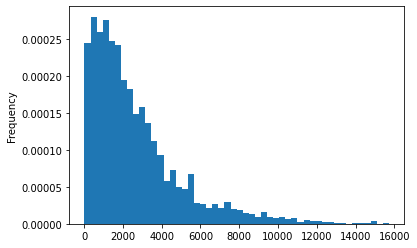

In [24]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [25]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 24098, dtype: int64

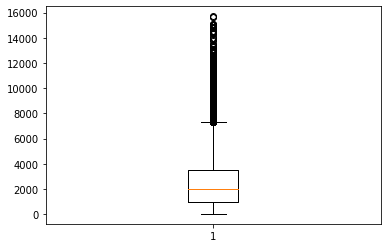

In [26]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [27]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.0 Q3 : 3505.0 IQR : 2536.0


In [28]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

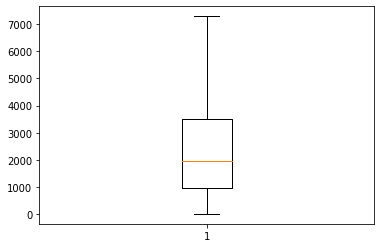

In [29]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [30]:
train['DAYS_EMPLOYED'].value_counts()

0.0       4059
3505.0    1158
401.0       53
1539.0      42
2087.0      39
          ... 
2582.0       1
5404.0       1
6372.0       1
1452.0       1
233.0        1
Name: DAYS_EMPLOYED, Length: 3121, dtype: int64

## **2. BEGIN_MONTH**

<AxesSubplot:ylabel='Frequency'>

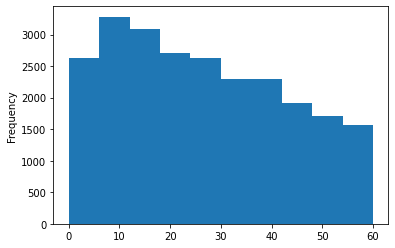

In [31]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [32]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [33]:
train['begin_month'].value_counts()

7.0     599
3.0     547
6.0     545
5.0     545
11.0    544
       ... 
56.0    223
59.0    215
0.0     214
60.0    210
57.0    208
Name: begin_month, Length: 61, dtype: int64

## **3. INCOME_TOTAL**

<AxesSubplot:ylabel='Frequency'>

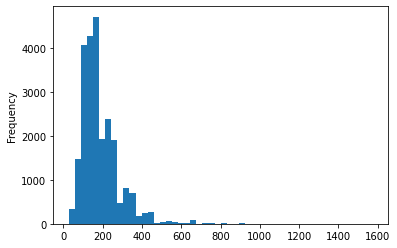

In [34]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

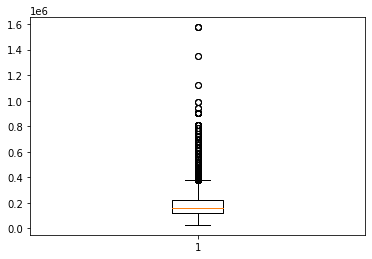

In [35]:
plt.boxplot(train['income_total'])
plt.show()

In [36]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

In [37]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [38]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

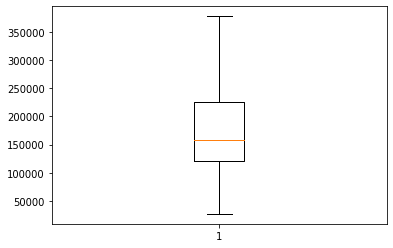

In [39]:
plt.boxplot(train['income_total'])
plt.show()

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train['income_total'] = scaler.fit_transform(train['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1))

In [63]:
test['income_total'].values

array([0.24358974, 0.30769231, 0.12071795, ..., 0.75641026, 0.43589744,
       0.69230769])

In [ ]:
""" scaler.fit(test['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1)) """

" scaler.fit(test['income_total'].values.reshape(-1,1))\ntest['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1)) "

## **4. Gender**, **Car**, **Reality**

In [ ]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## **5. DAYS_BIRTH**

In [64]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

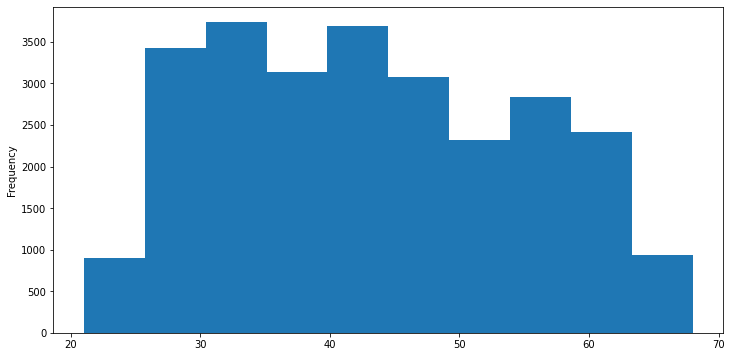

In [65]:
train['DAYS_BIRTH'].plot(kind='hist')

In [ ]:
def birth_catagory(value):
    ep = ''
    if value <= 30: ep = 'A'
    elif value <= 40: ep = 'B'
    elif value <= 50: ep = 'C'
    elif value <= 60: ep = 'D'
    elif value < 70: ep = 'E'
       
    return ep

In [ ]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x : birth_catagory(x))

In [66]:
train['DAYS_BIRTH'].value_counts()

37    903
27    836
40    820
28    809
34    796
39    795
32    772
33    753
41    750
38    749
42    733
35    724
43    717
30    716
31    691
36    686
46    674
29    671
44    671
47    654
48    631
51    625
54    619
57    611
50    593
59    587
56    586
60    584
45    577
53    564
58    554
49    542
52    539
55    461
62    454
63    396
61    389
26    388
64    386
25    358
24    271
65    240
66    199
23    159
22    109
67     85
68     23
21      7
Name: DAYS_BIRTH, dtype: int64

## **6. family_size**

In [67]:
train['family_size'].value_counts()

2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [68]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [69]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [70]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [71]:
train['family_size'].value_counts()

B    14106
A     5109
C     4632
D     2610
Name: family_size, dtype: int64

## **7. work_phone**, **phone**, **email**, **FLAG_MOBIL**

In [46]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])

train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])

## **8. CHILD_NUM**

In [42]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'Z'
    elif value == 1: ep = 'O'
    elif value == 2: ep = 'T'
    elif value >= 3: ep = 'M'
    
    return ep

In [43]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [44]:
train['child_num'].value_counts()

Z    16659
O     4935
T     2167
M      337
Name: child_num, dtype: int64

## **9. OCCYP_TYPE**

In [47]:
def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

train['income_box'] = train['income_total'].apply(lambda x : box_category(x))
test['income_box'] = test['income_total'].apply(lambda x : box_category(x))

In [48]:
train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_box'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

KMeans(n_clusters=3)

In [49]:
subset['Cluster'] = kmeans.labels_ 

In [62]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [63]:
test['occyp_type'] = test['occyp_type'].replace('Secret' , 'A')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [66]:
train['occyp_type'].value_counts()

B    10072
A     7415
C     4603
D     2008
Name: occyp_type, dtype: int64

In [67]:
test['occyp_type'].value_counts()

B    4032
A    3152
C    1955
D     861
Name: occyp_type, dtype: int64

# **데이터 중간 저장**

In [78]:
""" train.to_csv('../Data/Catdata.csv')
test.to_csv('../Data/Cattest.csv') """


" train.to_csv('../Data/Catdata.csv')\ntest.to_csv('../Data/Cattest.csv') "

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24098 entries, 0 to 26456
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          24098 non-null  int64  
 1   gender         24098 non-null  object 
 2   car            24098 non-null  object 
 3   reality        24098 non-null  object 
 4   child_num      24098 non-null  object 
 5   income_total   24098 non-null  float64
 6   income_type    24098 non-null  object 
 7   edu_type       24098 non-null  object 
 8   family_type    24098 non-null  object 
 9   house_type     24098 non-null  object 
 10  DAYS_BIRTH     24098 non-null  int64  
 11  DAYS_EMPLOYED  24098 non-null  float64
 12  FLAG_MOBIL     24098 non-null  object 
 13  work_phone     24098 non-null  object 
 14  phone          24098 non-null  object 
 15  email          24098 non-null  object 
 16  occyp_type     24098 non-null  object 
 17  family_size    24098 non-null  float64
 18  begin_

# **ENCODING**

In [88]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [89]:
train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True)

In [90]:
print(train_x.shape, test_x.shape, train_y.shape)

(26457, 39) (10000, 39) (26457, 1)


## 모델링

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=2021)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=2021))),
    ('cat', CatBoostClassifier(random_state=2021)),
    ('LGB', LGBMClassifier(random_state=2021))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)
clf.fit(X_train, y_train).score(X_val, y_val)

Learning rate set to 0.092151
0:	learn: 1.0468285	total: 6.53ms	remaining: 6.53s
1:	learn: 1.0060110	total: 23.5ms	remaining: 11.7s
2:	learn: 0.9730726	total: 40.8ms	remaining: 13.5s
3:	learn: 0.9460081	total: 48.5ms	remaining: 12.1s
4:	learn: 0.9236089	total: 84ms	remaining: 16.7s
5:	learn: 0.9050554	total: 102ms	remaining: 16.9s
6:	learn: 0.8896856	total: 118ms	remaining: 16.8s
7:	learn: 0.8766279	total: 134ms	remaining: 16.6s
8:	learn: 0.8656829	total: 143ms	remaining: 15.7s
9:	learn: 0.8564220	total: 151ms	remaining: 14.9s
10:	learn: 0.8484058	total: 162ms	remaining: 14.6s
11:	learn: 0.8419531	total: 177ms	remaining: 14.6s
12:	learn: 0.8361028	total: 185ms	remaining: 14s
13:	learn: 0.8313067	total: 224ms	remaining: 15.8s
14:	learn: 0.8274898	total: 233ms	remaining: 15.3s
15:	learn: 0.8242123	total: 254ms	remaining: 15.6s
16:	learn: 0.8208695	total: 265ms	remaining: 15.3s
17:	learn: 0.8181328	total: 275ms	remaining: 15s
18:	learn: 0.8156900	total: 315ms	remaining: 16.3s
19:	learn: 0

0.7055177626606198

In [116]:
y_pred = clf.predict_proba(test_x)
y_pred.shape

(10000, 3)

In [109]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf_):
    folds=StratifiedKFold(n_splits=4, shuffle=True, random_state=2021)
    outcomes = []
    sub=np.zeros((test_x.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf_.fit(X_train, y_train)
        
        predictions=clf_.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val['credit']), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf_.predict_proba(X_val)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

Learning rate set to 0.092151
0:	learn: 1.0471599	total: 6.51ms	remaining: 6.5s
1:	learn: 1.0064488	total: 28ms	remaining: 14s
2:	learn: 0.9734692	total: 45.6ms	remaining: 15.1s
3:	learn: 0.9465690	total: 54ms	remaining: 13.4s
4:	learn: 0.9244184	total: 58.2ms	remaining: 11.6s
5:	learn: 0.9060947	total: 74.9ms	remaining: 12.4s
6:	learn: 0.8906188	total: 89.2ms	remaining: 12.7s
7:	learn: 0.8777494	total: 97.3ms	remaining: 12.1s
8:	learn: 0.8668789	total: 105ms	remaining: 11.5s
9:	learn: 0.8576406	total: 136ms	remaining: 13.5s
10:	learn: 0.8497343	total: 153ms	remaining: 13.7s
11:	learn: 0.8431108	total: 168ms	remaining: 13.8s
12:	learn: 0.8374042	total: 183ms	remaining: 13.9s
13:	learn: 0.8327071	total: 198ms	remaining: 13.9s
14:	learn: 0.8288312	total: 213ms	remaining: 14s
15:	learn: 0.8254121	total: 227ms	remaining: 14s
16:	learn: 0.8219530	total: 240ms	remaining: 13.9s
17:	learn: 0.8192421	total: 256ms	remaining: 14s
18:	learn: 0.8169870	total: 267ms	remaining: 13.8s
19:	learn: 0.814

ValueError: operands could not be broadcast together with shapes (10000,3) (6615,3) (10000,3) 

In [100]:
from tensorflow.keras.utils import to_categorical

print(f"log_loss: {log_loss(to_categorical(y_test['credit']), y_pred)}")

log_loss: 0.7413526090356548


In [403]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


ada_pred=AdaBoostClassifier()
ada_pred.fit(X_train, y_train)
y_pred=ada_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

Train set: 
(19842, 39)
(19842, 1)
Validation set: 
(6615, 39)
(6615, 1)
log_loss: 1.0814809663129106


In [404]:
rf_pred=RandomForestClassifier(random_state=2021)
rf_pred.fit(X_train, y_train)
y_pred=rf_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 1.0121941455480854


In [405]:
gb_pred=GradientBoostingClassifier(random_state=2021)
gb_pred.fit(X_train, y_train)
y_pred=gb_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.793851547675101


In [406]:
cat_pred=CatBoostClassifier(random_state=2021, learning_rate = 0.11, iterations = 530)
cat_pred.fit(X_train, y_train, silent=True)
y_pred=cat_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7628095811501764


In [407]:
LGB_pred=LGBMClassifier(random_state=2021)
LGB_pred.fit(X_train, y_train)
y_pred=LGB_pred.predict_proba(X_val)

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")

log_loss: 0.7601919120634574


In [202]:
X_train.to_csv('../Data/LJH_X_train_1.csv', index=False)

<AxesSubplot:>

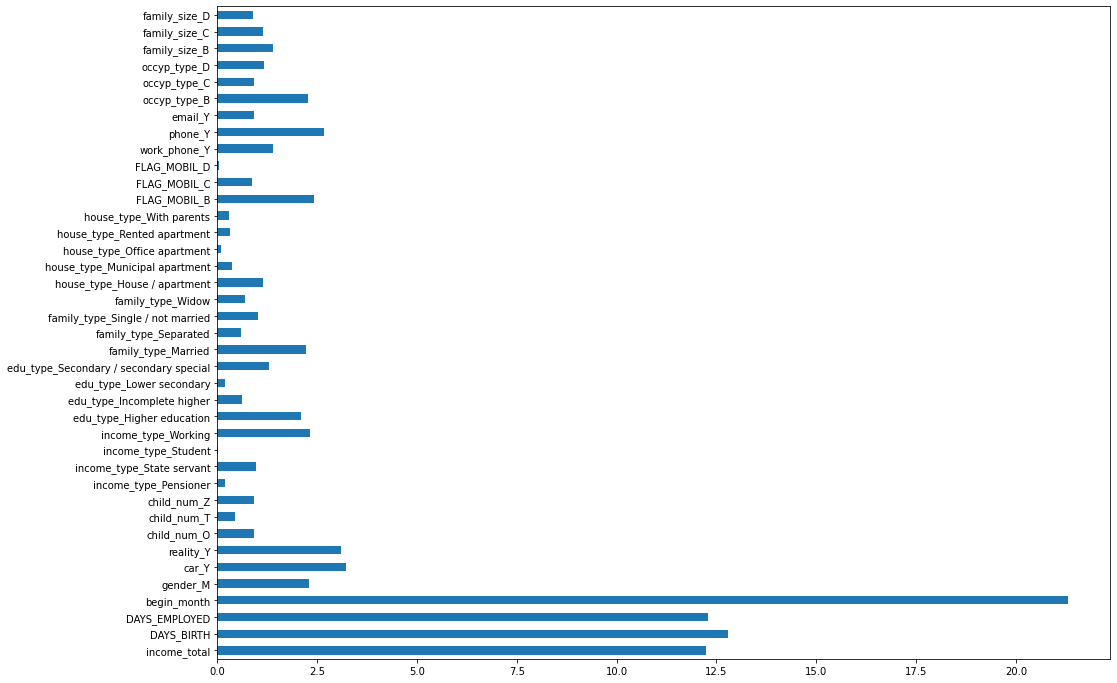

In [409]:
plt.rcParams['figure.figsize'] = (16,12)

pd.Series(cat_pred.feature_importances_, X_train.columns).plot(kind = 'barh')

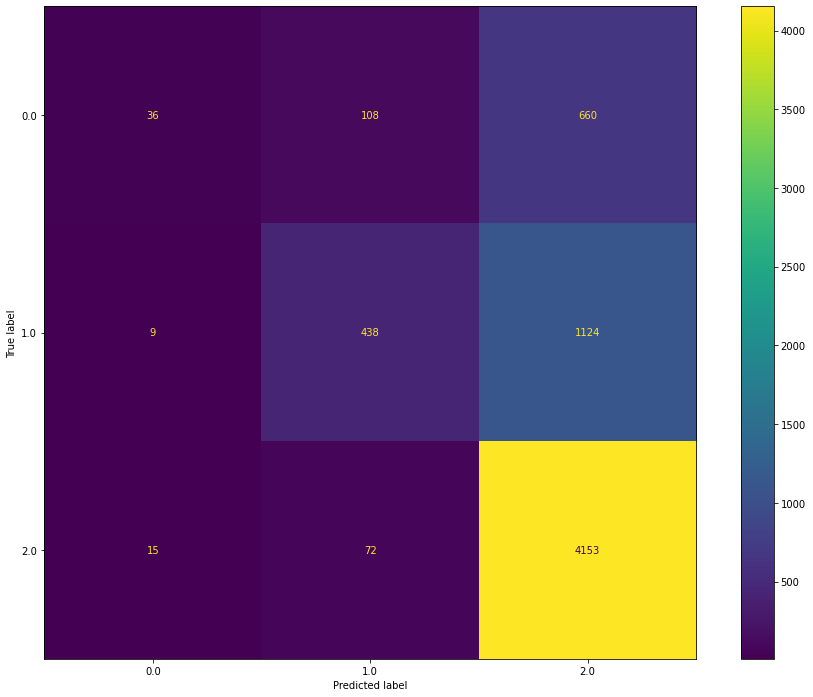

In [410]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(cat_pred, X_val, y_val)
plt.show()

In [117]:
submission.loc[:,1:] = y_pred

In [118]:
submission

,index,0,1,2
0,26457,0.065362,0.136095,0.798544
1,26458,0.265956,0.184300,0.549744
2,26459,0.057686,0.101657,0.840657
3,26460,0.116832,0.190388,0.692780
4,26461,0.103390,0.158103,0.738508
...,...,...,...,...
9995,36452,0.100365,0.212841,0.686794
9996,36453,0.171017,0.341658,0.487325
9997,36454,0.055991,0.089410,0.854599
9998,36455,0.346764,0.155590,0.497646


In [119]:
submission.to_csv('../Data/LJH_stacking.csv', index=False)